# Imports and functions

### Plotting functions

In [1]:
import torch
import torch.optim
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import optim
import numpy as np
import copy
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

#input: list of digit images
#output: plots of the digit images
def show_digits(digits):
    n = len(digits)
    if n==0:
        print("0 digits")
    fig, axs = plt.subplots(1, n, figsize=(70, 10))
    if n==1:
        print(digits[0].shape)
        axs.imshow(digits[0])
    else:
        for d in range(n):
            axs[d].set_title(str(digits[d].shape))
            axs[d].imshow(digits[d])
    plt.tight_layout()

#input: epoch_stats dictionary (the output of train_and_validate_model) and best_epoch
#output: plots accs and vars with respect to epochs. Places diamond at the "best_epoch" (the epoch with lowest validation loss)
def plot_accs_and_losses_wrt_epochs(epoch_stats, best_epoch):
    if 'model_state_dict' in epoch_stats:
        epoch_stats_df = pd.DataFrame.from_dict(epoch_stats).drop('model_state_dict', axis=0).transpose()
    else:
        epoch_stats_df = pd.DataFrame.from_dict(epoch_stats).transpose()
    fig, ax = plt.subplots( )
    
    epoch_stats_df.plot(y=['tr_acc', 'val_acc'], ax=ax, style='-d', markevery=[best_epoch], 
                        title='Acc and Loss as a function of Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylim(0.96, 1.0002)
    ax.set_ylabel('Accuracy')
    plt.legend(loc='center')
    
    ax2 = ax.twinx()
    epoch_stats_df.plot(y=['tr_loss', 'val_loss'], style = '--d', ax=ax2, markevery=[best_epoch])
    ax2.set_ylabel('Loss')
    ax2.set_ylim(0.000001, 0.1)
    plt.legend(loc='center right')
    plt.tight_layout()

### Functions for training the model

In [9]:
#takes in the output from the model, computes class prpobabilites for each instance
#takes the class with greatest probability as prediciton, and computes accuracy based on the true classes y
#the model output should be a NxC tensor where N is number of instances and C number of classes. y is a Nx1 tensor
def softmax_accuracy(model_output, y):
    class_probs = model_output / model_output.exp().sum(-1).view(-1, 1)
    preds = torch.argmax(model_output, dim=1)
    return (class_probs.argmax(dim=1) == y).float().mean().item()

#when given an optimizer, this function computes the loss of 
#the prediciton made by the given model using the given loss_func.
#if not given an optimizer, it will also compute the accuracy
def loss_batch(model, loss_func, xb, yb, opt=None):
    model_output = model(xb)
    #compute the loss
    loss = loss_func(model_output, yb)
    #backrop if given an optimizer
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    #calculate accuracy if not given an optimizer
    acc = None
    if opt is None:
        acc = softmax_accuracy(model_output, yb)
    
    return acc, loss.item(), len(xb)

#computes the weighted average of the values, using the batch sizes as weights
def compute_average_weighted_by_batch_sizes(values, batch_sizes):
    return np.sum(np.multiply(values, batch_sizes)) / np.sum(batch_sizes)

#input: the training/validation data and labels must be tensors. batch size an integer
#output: training and validation DataLoaders
def get_DataLoaders(x_train, y_train, x_valid, y_valid, bs):
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    
    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    
    return train_dl, valid_dl          

#for each epoch, fits model using the given parameters and DataLoaders
#output:
#   - epoch_stats: a dictionary of the dictionaries of the accuracies and losses at each epoch for tr and val
#   - best_epoch: the epoch number with the lowest validation loss (epochs start at 0)
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
    epoch_stats = {}
    #keep track of the number of epochs that have passed since the last time val_loss decreased
    count = 0
    for epoch in range(epochs):
        #print
        print(f"\n Lr = {opt.param_groups[0]['lr']}")
        

        #train model using the batches in the train DataLoader
        model.train()
        for xb, yb in train_dl:
            #compute loss and backprop
            loss_batch(model, loss_func, xb, yb, opt)
            
        #once we finish going through the entire dataset (i.e. one epoch)
        #we compute the loss and accuracy on both the training and validation sets
        model.eval()
        with torch.no_grad():
            #note: the reason we compute the accs and losses in this weird way is (I think) because sometimes
            #the dataset might be too large to use all at the same time... 
            #(this is how it's done in "what is torch.nn really tutorial")
            val_accs, val_losses, val_batch_sizes = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
            tr_accs, tr_losses, tr_batch_sizes = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl])
        val_loss = compute_average_weighted_by_batch_sizes(val_losses, val_batch_sizes)
        tr_loss = compute_average_weighted_by_batch_sizes(tr_losses, tr_batch_sizes)
        val_acc = compute_average_weighted_by_batch_sizes(val_accs, val_batch_sizes)
        tr_acc = compute_average_weighted_by_batch_sizes(tr_accs, tr_batch_sizes)
        print(f"Epoch: {epoch}, val_loss: {val_loss}, train_loss: {tr_loss}\n\t  val_acc: {val_acc}, train_acc:{tr_acc}")
        
        #save the loss and accuracies on both sets in a dictionary under the key of the epoch
        #also save the model state so we can recover the best model
        epoch_stats[str(epoch)] = {'model_state_dict':copy.deepcopy(model.state_dict()), 'val_loss':val_loss, 'tr_loss':tr_loss, 'val_acc':val_acc, 'tr_acc':tr_acc, 'lr': opt.param_groups[0]['lr']}
        
        #if it's the 0th epoch, don't do anything
        if epoch == 0:
            continue
        #if not, then:
        else:
            #if the current val_loss is smaller than the smallest val_loss, set count to 0
            if epoch_stats[str(epoch)]['val_loss'] < epoch_stats[str(epoch-1-count)]['val_loss']:
                count = 0
            #if not, then add 1 to the count.
            else:
                count += 1
                
        #if it's been patience epochs since val_loss decreased, exit training  
        if count == patience:
            print(f"EARLY STOPPING!!!")
            break

        #update lr according to scheduler
        scheduler.step(epoch_stats[str(epoch)]['val_loss'])
        
            
    #return the epoch statistics dictionary and the epoch that gave us the smallest loss
    print(f"BEST_EPOCH: {str(epoch-count)}")
    return (epoch_stats, epoch-count) 

#creates a model, dataloaders and optimizer and calls the fit function
#returns the output of the fit method:
def train_and_validate_model(x_tr, y_tr, x_val, y_val, lr, mom, bs, epochs, patience):
    #create the DataLoaders that will handle the batch configurations
    train_dl, valid_dl = get_DataLoaders(x_tr, y_tr, x_val, y_val, bs=bs)
    #create the model
    model = Mnist_CNN()
    #create the optimizer
    #opt = optim.Adam(model.parameters())
    opt = optim.SGD(model.parameters(), lr=lr, momentum=mom)
    return fit(epochs=epochs, patience=patience, model=model, loss_func=F.cross_entropy,
               opt=opt, train_dl=train_dl, valid_dl=valid_dl)

### Functions for cross-validation and grid search

In [3]:
#returns a dictionary of the epoch_stats dictionaries for each grid
def grid_search_with_no_cross_val(digits, labels, learning_rates, momentums, batch_sizes, epochs, patience):
    #shuffle the data and randomly sample a validation and tr set (we will use the same validation and training for all grids)
    size_ds = len(digits) 
    p = np.random.permutation(size_ds)
    x_tr = digits[p][:(size_ds*19)//20]; y_tr = labels[p][:(size_ds*19)//20]
    x_val = digits[p][(size_ds*19)//20:]; y_val = labels[p][(size_ds*19)//20:]
    #convert the arrays into tensors
    x_tr, y_tr, x_val, y_val = map(torch.tensor, (x_tr, y_tr, x_val, y_val))

    #create the grid of hyperparameter tuples
    Hyper_tuple = namedtuple('Hyper_tuple', ['lr', 'mom', 'bs'])
    hyper_tuple_grid = [Hyper_tuple(lr=lr, mom=mom, bs=bs) for lr in learning_rates for mom in momentums for bs in batch_sizes]

    print(f'We will iterate over the following grid of hyperparameters: {hyper_tuple_grid}')

    #loop throught the hyper_tuple_grid and save the epoch stats aswell as the best_epochs
    dict_of_epoch_stats = {}
    for h_tuple in hyper_tuple_grid:
        print(f'\nLR: {h_tuple.lr} - MOM: {h_tuple.mom} - BS: {h_tuple.bs}')
        #get the epoch stats and the best epoch number 
        epoch_stats, best_epoch = train_and_validate_model(x_tr, y_tr, x_val, y_val, h_tuple.lr, h_tuple.mom, h_tuple.bs, epochs, patience)
        #store the epoch stats and the best_epoch in the final dictionary
        dict_of_epoch_stats[h_tuple] = {'epoch_stats': epoch_stats, 'best_epoch': best_epoch}
        
    return dict_of_epoch_stats
    
    
  
#cross_validate takes in the number of datapoints (n) and the number of folds we want to divide our data into (n_folds)
#it then yields the training_indices and the validation_indices
def compute_cross_validation_indicies(n, n_folds):
    n_val = n // n_folds
    for f in range(n_folds):
        tr_inds = []
        val_inds = list(range(f * n_val, (f+1)*n_val))
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        yield tr_inds, val_inds


#creates a dataframe of the mean/var accs/losses for all combinations of hyperparameters
def create_hyper_grid_with_cross_val(digits, labels, learning_rates, momentums, batch_sizes, epochs, patience, n_folds):
    #shuffle the data
    size_ds = len(digits)
    p = np.random.permutation(size_ds)
    digits = digits[p]; labels = labels[p];
    
    #initialize the hyper_grid
    hyper_grid_index = pd.MultiIndex.from_product([learning_rates, momentums, batch_sizes], names=['learning rate', 'momentum', 'batch size'])
    hyper_grid = pd.DataFrame(index=hyper_grid_index, columns=['val_acc_mean', 'tr_acc_mean', 'val_acc_var', 'tr_acc_var', 
                                                               'best_epoch_mean', 'best_epoch_var', 'val_loss_mean', 'tr_loss_mean'])

    #loop through the hyper_grid (i is not used)
    for i, (lr, mom, bs) in enumerate(hyper_grid.index):
        #cross validate the given combination of hyperparams and maintain lists to store the accuracies,
        #losses and best_epochs so we can take the average at the end of the cross validation
        tr_accs = []; val_accs = []; tr_losses = []; val_losses = []; best_epochs = []
        for f, (tr_inds, val_inds) in enumerate(compute_cross_validation_indicies(size_ds, n_folds)):
            print(f'\nLR: {lr} - MOM: {mom} - BS: {bs} - FOLD: {f}')
            #seperate the training and validation sets
            x_tr = digits[tr_inds];   y_tr=labels[tr_inds]
            x_val = digits[val_inds]; y_val=labels[val_inds]
            print(f"Training set size: {len(x_tr)}"); print(f"Validation set size: {len(x_val)}")
            
            #convert the arrays into tensors
            x_tr, y_tr, x_val, y_val = map(torch.tensor, (x_tr, y_tr, x_val, y_val))
            
            #get the epoch stats adn the best epoch number 
            epoch_stats, best_epoch = train_and_validate_model(x_tr, y_tr, x_val, y_val, lr, mom, bs, epochs, patience)
            
            #retreive the losses and accuracies of that best epoch
            best_epochs.append(best_epoch);    
            e = epoch_stats[str(best_epoch)]
            val_accs.append(e['val_acc']); tr_accs.append(e['tr_acc']); val_losses.append(e['val_loss']); tr_losses.append(e['tr_loss']); 

        #once cross validation is done, store the mean/var accs, losses and best_epochs in the hyper_grid
        idx = pd.IndexSlice
        hyper_grid.loc[idx[lr, mom, bs]] = [np.mean(val_accs), np.mean(tr_accs), np.var(val_accs), np.var(tr_accs),
                                            np.mean(best_epochs), np.var(best_epochs), np.mean(val_losses), np.mean(tr_losses)]

    return hyper_grid

def plot_acc_vs_hyperparam(hyper_grid, hyperparam, ylim=(0,1), figsize=(50, 30)):
    #get the other 2 hyperparameters
    other_hp_1, other_hp_2 = [hp for hp in ['learning rate', 'momentum', 'batch size'] if hp != hyperparam]
    #the dfs of the mean training and validation accuracies, where the index of the dfs is the given hyperparam
    #(the other two are made into columns via the unstack method)
    val_acc_means_and_vars = hyper_grid.unstack(level=[other_hp_1, other_hp_2]).loc[:, ['val_acc_mean', 'val_acc_var']]
    tr_acc_means = hyper_grid.unstack(level=[other_hp_1, other_hp_2])['tr_acc_mean']
    #number of axs to create
    n_axs = tr_acc_means.shape[1]    
    #number of different values of the first "other" hyperparameter
    n_other_1 = len(tr_acc_means.columns.levels[0])
    #number of different values of the second "other" hyperparameter
    n_other_2 = len(tr_acc_means.columns.levels[1])
    
    #our figure consists of n_other_1Xn_other_2 subplots (axs), 
    #on each axs the accuracy is plotted vs the given hyperparam
    fig, axs = plt.subplots(nrows=n_other_1, ncols=n_other_2, figsize=figsize)
    axs = axs.ravel()
    for a in range(n_axs):
        ax=axs[a]
        idx = pd.IndexSlice
        #get the values of the 2 other hyperparameters
        other_hp_1_value = tr_acc_means.columns[a][0]
        other_hp_2_value = tr_acc_means.columns[a][1]
        #plot the accuracy means and the variances for the validation and the means for training 
        val_acc_means_and_vars.plot(ax=ax, y=('val_acc_mean', other_hp_1_value, other_hp_2_value),
                                    title=f'{other_hp_1}: {other_hp_1_value} - {other_hp_2}: {other_hp_2_value}',
                                    yerr=2*val_acc_means_and_vars.loc[idx[:, ('val_acc_var', other_hp_1_value, other_hp_2_value)]])
        tr_acc_means.plot(ax=ax, y=(other_hp_1_value, other_hp_2_value), grid=True, ylim=ylim)  
                                              
        ax.legend(["training accuracy", "validation accuracy"]);
                                                                              
    plt.tight_layout()

# GPU?

In [ ]:
print(torch.cuda.device_count())


1


# Get the training data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Datasets in h5 file: ['digits', 'labels']
Shape of labels: (167874,)
Shape of digits : (167874, 10, 10)
[5 9 1 5 1 4 2 4 9 2]


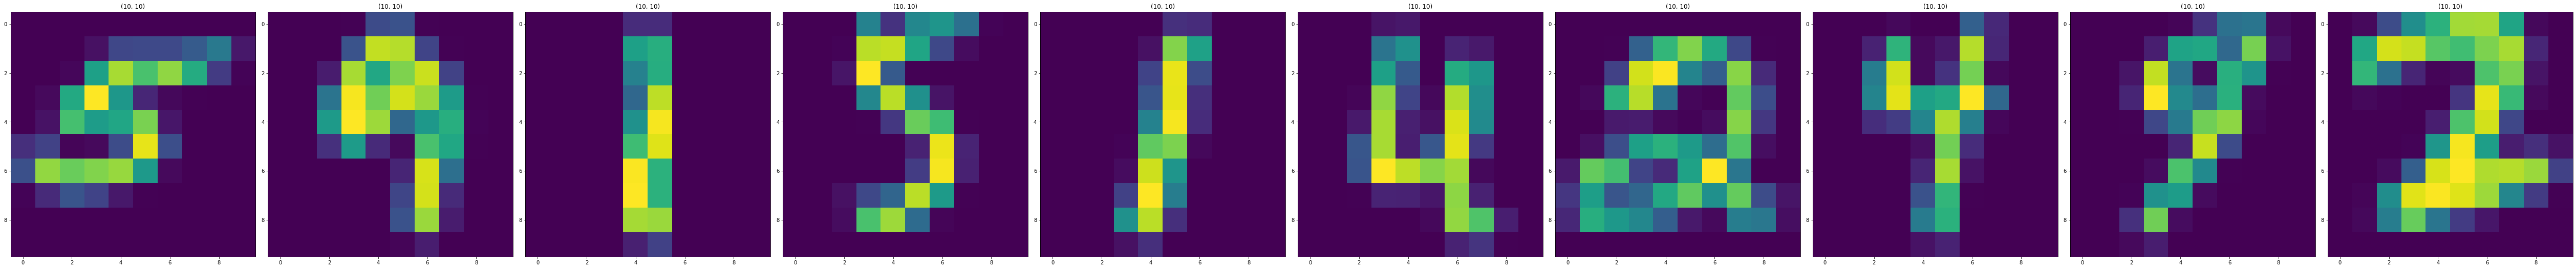

In [5]:
#ENTER PATH TO THE DATASET
path_to_training_dataset = '/content/gdrive/MyDrive/COMP551-Project3/Data/10x10_adjusted_digits_and_labels_167874instances.hdf5'
with h5py.File(path_to_training_dataset, 'r') as f:
    print(f'Datasets in h5 file: {list(f.keys())}')
    #convert to long because pytorch requires categorical output to be long
    labels = np.array(f['labels'], dtype=np.long)
    #convert to float because pytorch requires inputs to be float
    digits = np.array(f['digits'], dtype=np.float32)
    print(f"Shape of labels: {labels.shape}")
    print(f"Shape of digits : {digits.shape}")
  
#check that the labels correspond to the digits
print(labels[20023:20033])
show_digits(digits[20023:20033])

# Define a model and check it's performence by manually entering the hyperparams

### Build the model

In [6]:
#ARCHITECT:0
#Model. Make sure the model does not output softmax or any other type of probability. 
#this is calculated in the loss func
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(10, 56, kernel_size=3, padding=1)

    self.maxpool = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(56*5*5, 700);
    self.fc2 = nn.Linear(700, 350);
    self.fc3 = nn.Linear(350, 100);
    self.fc4 = nn.Linear(100, 50);
    self.fc5 = nn.Linear(50, 10);

    self.dropout = nn.Dropout(0.25)

  def forward(self, xb):
    xb = xb.view(-1, 1, 10, 10);
    xb = F.relu(self.conv1(xb));
    xb = F.relu(self.conv2(xb));
    xb = F.relu(self.conv3(xb));

    xb = self.maxpool(xb);
    xb = xb.view(-1, 56*5*5);

    xb = F.relu(self.fc1(xb));
    xb = self.dropout(xb);
    xb = F.relu(self.fc2(xb));
    xb = self.dropout(xb);
    xb = F.relu(self.fc3(xb));
    xb = self.dropout(xb);
    xb = F.relu(self.fc4(xb));
    xb = self.dropout(xb);
    xb = self.fc5(xb);
    return xb

### Enter hyperparams and train and validate the model 

In [10]:
#train and validate the model on a certain combination of: lr, mom, bs, epoch, patience
size_ds = len(digits) 
p = np.random.permutation(size_ds)
x_tr = digits[p][:(size_ds*49)//50]; y_tr = labels[p][:(size_ds*49)//50]
x_val = digits[p][(size_ds*49)//50:]; y_val = labels[p][(size_ds*49)//50:]
#convert the arrays into tensors
x_tr, y_tr, x_val, y_val = map(torch.tensor, (x_tr, y_tr, x_val, y_val))


#ENTER THE HYPERPARAMS YOU WANT TO TEST WITH
epoch_stats, best_epoch = train_and_validate_model(x_tr, y_tr, x_val, y_val, lr=0.001, 
                                                   mom=0.95, bs=1000, epochs=500, patience=30)


 Lr = 0.001
Epoch: 0, val_loss: 0.3858049371861645, train_loss: 0.39422857654576127
	  val_acc: 0.8850506353832697, train_acc:0.8853971659057513

 Lr = 0.001
Epoch: 1, val_loss: 0.18374484372749578, train_loss: 0.19508832290581313
	  val_acc: 0.9434187068621128, train_acc:0.9415497574565297

 Lr = 0.001
Epoch: 2, val_loss: 0.12324922215892418, train_loss: 0.1327420665246165
	  val_acc: 0.9603930835996518, train_acc:0.9604658497545309

 Lr = 0.001
Epoch: 3, val_loss: 0.08991293821255318, train_loss: 0.10199738629306326
	  val_acc: 0.9726027452640409, train_acc:0.9691944875730844

 Lr = 0.001
Epoch: 4, val_loss: 0.07631956885317523, train_loss: 0.08458513680480206
	  val_acc: 0.9806432571348652, train_acc:0.9746954703754743

 Lr = 0.001
Epoch: 5, val_loss: 0.07172478954216212, train_loss: 0.07383424061208978
	  val_acc: 0.9785586498975044, train_acc:0.9779352766728574

 Lr = 0.001
Epoch: 6, val_loss: 0.05707305769850414, train_loss: 0.06009736741033905
	  val_acc: 0.9845145983025743, tr

### Visualize the loss and accuracy as a function of epochs

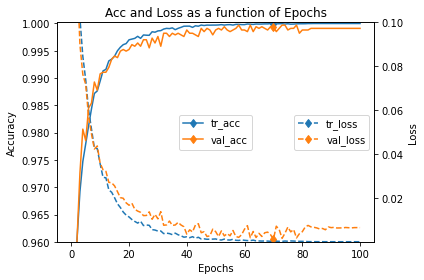

In [11]:
plot_accs_and_losses_wrt_epochs(epoch_stats, best_epoch) #places a diamond at the epoch with lowest val loss

### Save the model we had at some desired epoch

In [12]:
#create a new model with the same architecture
model = Mnist_CNN()
#load the state of the model at the desired epoch (not necessarily the best_epoch in terms of loss!??)
desired_epoch = best_epoch #you can put any epoch here, not just best_epoch
desired_state_dict = epoch_stats[str(desired_epoch)]['model_state_dict'] #get the state at the desired epoch
model.load_state_dict(desired_state_dict) #load it into the model

#CAREFUL DO NOT TO OVERWRITE ANOTHER MODEL
path_to_model = r'/content/gdrive/MyDrive/COMP551-Project3/Data/architect0_scheduled_lr.pt'  #enter val loss and val acc at that epoch

In [13]:
torch.save(model, path_to_model)

In [16]:
#just to be sure it worked, load the model we just saved an predict the validation data.
#We should get (almost) the same accuracy
loaded_model = torch.load(path_to_model)
loaded_model.eval()
with torch.no_grad():
    print(f"validation acc of loaded model: {softmax_accuracy(loaded_model(x_val), y_val)}")

validation acc of loaded model: 0.9994044303894043


# Hyperparam grid search without cross validation

### Grid search without cross-validation

In [ ]:
#ENTER THE DIFFERENT HYPERPARAMS AND RUN
learning_rates = [0.0005]                     # 0.05, 0.005, 0.001, 0.0005]
momentums = [0.97]                           #, 0.95, 0.99]
batch_sizes = [256, 512, 1024, 2048]         #, 512, 1024, 2048]
epochs = 50
patience = 15
dict_of_epoch_stats = grid_search_with_no_cross_val(digits, labels, learning_rates, momentums, batch_sizes, epochs, patience)

We will iterate over the following grid of hyperparameters: [Hyper_tuple(lr=0.0005, mom=0.97, bs=256), Hyper_tuple(lr=0.0005, mom=0.97, bs=512), Hyper_tuple(lr=0.0005, mom=0.97, bs=1024), Hyper_tuple(lr=0.0005, mom=0.97, bs=2048)]

LR: 0.0005 - MOM: 0.97 - BS: 256
Epoch: 0, val_loss: 0.15666359915090283, train_loss: 0.1558106469239452
	  val_acc: 0.9530617111718226, train_acc:0.9544456984873012
Epoch: 1, val_loss: 0.08645733359074746, train_loss: 0.08354024520068651
	  val_acc: 0.9756969259073259, train_acc:0.9750438926810157
Epoch: 2, val_loss: 0.0575549134863454, train_loss: 0.05360864593322964
	  val_acc: 0.9830831548472885, train_acc:0.9847065462873549
Epoch: 3, val_loss: 0.04627294925946635, train_loss: 0.0388449647930337
	  val_acc: 0.9872527990791097, train_acc:0.9888512666344433
Epoch: 4, val_loss: 0.038111450576216996, train_loss: 0.02906832044020553
	  val_acc: 0.9893971879282877, train_acc:0.9913782292570062
Epoch: 5, val_loss: 0.03222081588156484, train_loss: 0.022865710714

### Save grid search results (dict_of_epoch_stats) as json

In [ ]:
with open(r'/content/gdrive/MyDrive/COMP551-Project3/Data/David_grid.json', 'w') as f:
    json.dump({str(k): v for k, v in dict_of_epoch_stats.items()}, f)

### Load grid search results

In [44]:
with open(r'/content/gdrive/MyDrive/COMP551-Project3/Data/David_grid.json', 'r') as f:
    d1 = json.load(f)
grid_1 =  {}
grid_1[(0.0005, 0.97, 256)] = d1['Hyper_tuple(lr=0.0005, mom=0.97, bs=256)']
grid_1[(0.0005, 0.97, 512)] = d1['Hyper_tuple(lr=0.0005, mom=0.97, bs=512)']
grid_1[(0.0005, 0.97, 1024)] = d1['Hyper_tuple(lr=0.0005, mom=0.97, bs=1024)']
grid_1[(0.0005, 0.97, 2048)] = d1['Hyper_tuple(lr=0.0005, mom=0.97, bs=2048)']


with open(r'/content/gdrive/MyDrive/COMP551-Project3/Data/Daniel_grid.json', 'r') as f:
    d2 = json.load(f)
grid_2 = {}
grid_2[(0.001, 0.9, 256)] = d2['Hyper_tuple(lr=0.001, mom=0.9, bs=256)']
grid_2[(0.001, 0.9, 512)] = d2['Hyper_tuple(lr=0.001, mom=0.9, bs=512)']
grid_2[(0.001, 0.9, 1024)] = d2['Hyper_tuple(lr=0.001, mom=0.9, bs=1024)']
grid_2[(0.001, 0.9, 2048)] = d2['Hyper_tuple(lr=0.001, mom=0.9, bs=2048)']

hyper_grid = {**grid_1, **grid_2}


### Plot grid search results

(0.0005, 0.97, 256)
(0.0005, 0.97, 512)
(0.0005, 0.97, 1024)
(0.0005, 0.97, 2048)
(0.001, 0.9, 256)
(0.001, 0.9, 512)
(0.001, 0.9, 1024)
(0.001, 0.9, 2048)


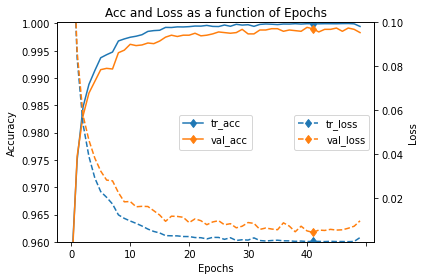

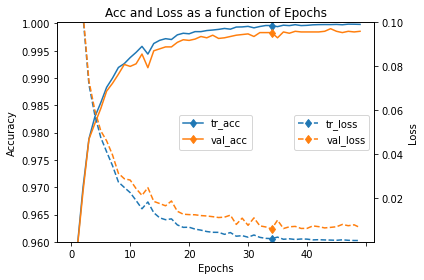

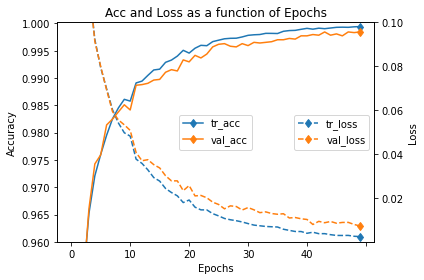

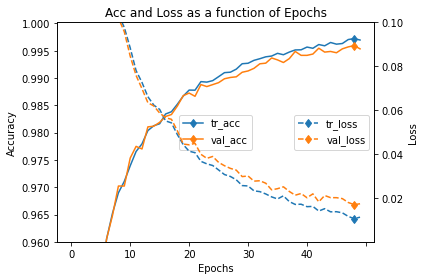

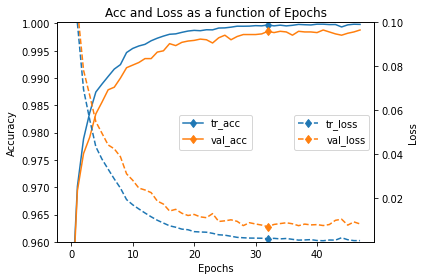

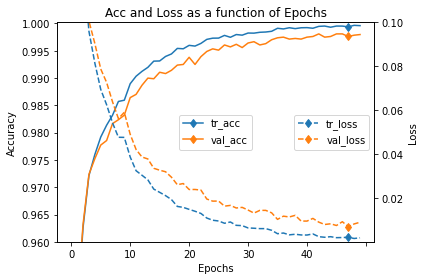

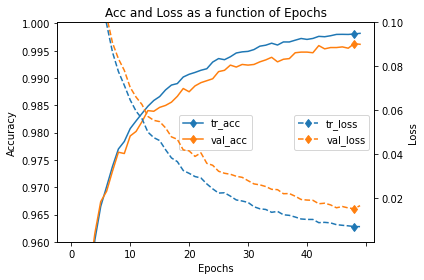

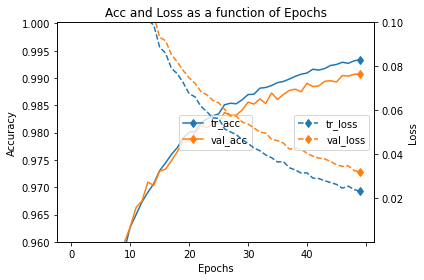

In [57]:
for key in hyper_grid.keys():
    print(key)
    plot_accs_and_losses_wrt_epochs(hyper_grid[key]['epoch_stats'], hyper_grid[key]['best_epoch'])

# Cross_Validate

### Plot cross-validation results

In [ ]:
#we plot accuracy vs one of ['learning rate', 'momentum', 'batch size'] -- strings must be exact
#if some plots don't have a line, change the ylim.
plot_acc_vs_hyperparam(hyper_grid, 'batch size', ylim=(0.,1.1))

# Testing

### Get the testing data

In [17]:
path_to_test_digits = r'/content/gdrive/MyDrive/COMP551-Project3/Data/testing_data_10X10.hdf5'
test_digits = []
with h5py.File(path_to_test_digits, 'r') as f:
    for i in range(14000):
      test_digits.append(np.array(f[str(i)], dtype=np.float32))
print(f'"test_digits" is of type: {type(test_digits)} with length {len(test_digits)}')
print(f'Each element is a {type(test_digits[0])} of 1 to 5 digits of size 10x10 and of type {type(test_digits[0][0])} each')
t = [digit for l in test_digits for digit in l]
print(len(t))
np.sum(list(map(lambda digit: digit.shape == (10, 10), t)))

"test_digits" is of type: <class 'list'> with length 14000
Each element is a <class 'numpy.ndarray'> of 1 to 5 digits of size 10x10 and of type <class 'numpy.ndarray'> each
42116


42116

### Load a model

In [18]:
# (the model you load must have the architecture of the Mnist class defined in "Build the model")
path_to_model = r'/content/gdrive/MyDrive/COMP551-Project3/Data/architect0_scheduled_lr.pt'
model = torch.load(path_to_model)
model.eval()  #VERY IMPORTANT

Mnist_CNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1400, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

### Predict test data

In [19]:
test_digits = list(map(torch.tensor, test_digits))
# print("We convert both inner ndarrays in test_digits to tensors")
# print(type(test_digits))
# print(type(test_digits[0]))
# print(type(test_digits[0][0]))
def construct_preds_dictionary(model, test_digits):
  lengths = []
  predictions_dict = {'Id':[], 'Label':[]}
  with torch.no_grad():
    for i in range(len(test_digits)):
      digits = test_digits[i]
      lengths.append(len(digits))
      number_of_10s = 5 - len(digits)
      model_output = model(digits)
      preds = torch.argmax(model_output, dim=1).tolist()
      preds.extend([10]*number_of_10s)
      preds_str = ''.join(map(str, preds ))
      predictions_dict['Id'].append(i); predictions_dict['Label'].append(preds_str)
  return predictions_dict, lengths


preds_dict, lengths = construct_preds_dictionary(model, test_digits)

In [24]:
preds_dict['Label'][12873]

'24308'

### Store the predictions

In [25]:
preds_df = pd.DataFrame(preds_dict)
path_to_save_predictions = r'/content/gdrive/MyDrive/COMP551-Project3/Data/PREDS_architect0_scheduled_lr.csv'
preds_df.to_csv(path_to_save_predictions, index=False)